# Project 1: Employee salary prediction

The objective of this case study is to predict the employee salary based on the number of years of experience.
In simple linear regression, we predict the value of one variable Y based on another variable X.
X is called the independent variable and Y is called the dependant variable.
Why simple? Because it examines relationship between two variables only.
Why linear? when the independent variable increases (or decreases), the dependent variable increases (or decreases) in a linear fashion.

In [1]:
# install seaborn library
!pip install seaborn

import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [42]:
#read the csv file 
salary_df = pd.read_csv('file:///Users/vjovanovic/Desktop/SageMaker/1. Employee salary prediction/salary.csv')

In [43]:
salary_df.head(5)

,YearsExperience,Salary
0,1.1,39343
1,1.3,46205
2,1.5,37731
3,2.0,43525
4,2.2,39891


In [8]:
salary_df.tail(5)

,YearsExperience,Salary
30,11.2,127345
31,11.5,126756
32,12.3,128765
33,12.9,135675
34,13.5,139465


<AxesSubplot:>

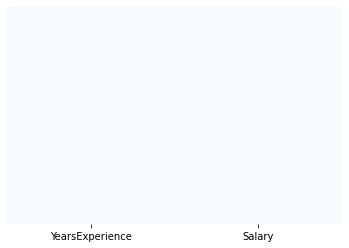

In [44]:
sns.heatmap(salary_df.isna(), yticklabels = False, cbar = False, cmap="Blues")

In [45]:
salary_df.iloc[0]

YearsExperience        1.1
Salary             39343.0
Name: 0, dtype: float64

MINI CHALLENGE
What are the number of years of experience corresponding to employees with minimum and maximim salaries?

In [50]:
salary_df['Salary'].min()

37731

In [53]:
salary_df['Salary'].max()

139465

In [51]:
max = salary_df[salary_df['Salary']==salary_df['Salary'].max()]

In [52]:
max

,YearsExperience,Salary
34,13.5,139465


In [55]:
min = salary_df[salary_df['Salary']==salary_df['Salary'].min()]
min

,YearsExperience,Salary
2,1.5,37731


array([[<AxesSubplot:title={'center':'YearsExperience'}>,
        <AxesSubplot:title={'center':'Salary'}>]], dtype=object)

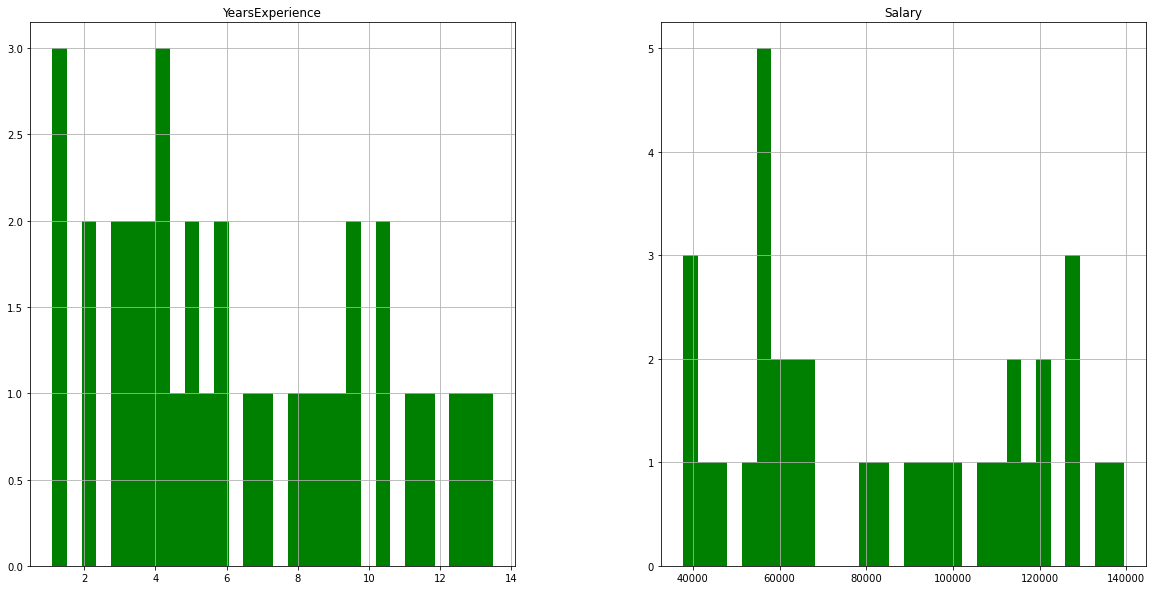

In [56]:
salary_df.hist(bins = 30, figsize = (20,10), color = 'g')



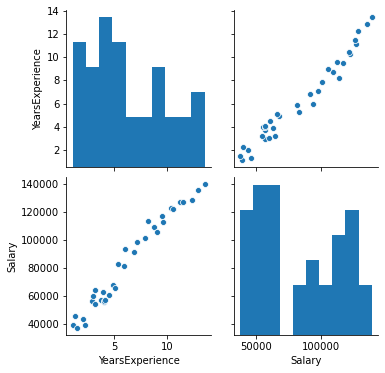

In [57]:
sns.pairplot(salary_df)

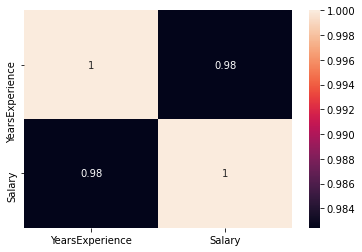

In [58]:
corr_matrix = salary_df.corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

<AxesSubplot:xlabel='YearsExperience', ylabel='Salary'>

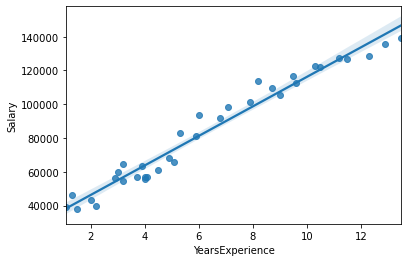

In [64]:
sns.regplot(x='YearsExperience', y='Salary', data=salary_df)

In [65]:
X = salary_df[['YearsExperience']]
y = salary_df[['Salary']]

In [67]:
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [70]:
y.shape

(35, 1)

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape

(28, 1)

MINI CHALLENGE
Try splitting the data into 75% for training and the rest for testing
Verify that the split was successful by obtaining the shape of both X_train and X_test
Did you notice any change in the order of the data? why?

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train.shape

(26, 1)

In [78]:
X_test.shape

(7, 1)

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

reg = LinearRegression(fit_intercept = True)
reg.fit(X_train, y_train)



LinearRegression()

In [86]:
reg_acc = reg.score(X_test, y_test)
reg_acc

0.9674700524888384

In [87]:
print('Linear Model Coefficient (m): ', reg.coef_)
print('Linear Model Coefficient (b): ', reg.intercept_)

Linear Model Coefficient (m):  [[8758.103]]
Linear Model Coefficient (b):  [29191.652]


In [89]:
y_predict = reg.predict(X_test)
y_predict

array([[ 65099.87 ],
       [ 88746.75 ],
       [ 80864.45 ],
       [147426.03 ],
       [113269.44 ],
       [119400.11 ],
       [ 64224.062]], dtype=float32)

Text(0.5, 1.0, 'Salary vs. Years of Experience')

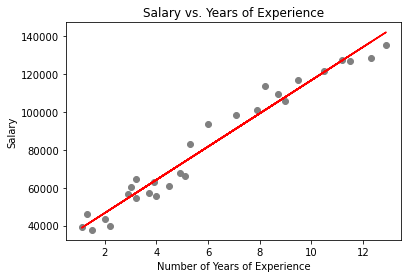

In [91]:
plt.scatter(X_train, y_train, color = 'gray')
plt.plot(X_train, reg.predict(X_train), color = 'red')
plt.ylabel('Salary')
plt.xlabel('Number of Years of Experience')
plt.title('Salary vs. Years of Experience')

MINI CHALLENGE
Use the trained model, obtain the salary corresponding to eployees who have years of experience = 5

In [99]:
num = [[5]]
num

[[5]]

In [100]:
reg.predict(num)

array([[72982.16503906]])

# Train a linear learner through SageMaker

In [104]:
# Boto3 is the Amazon Web Services (AWS) Software Development Kit (SDK) for Python
# Boto3 allows Python developer to write software that makes use of services like Amazon S3 and Amazon EC2

import sagemaker #ovo je instalirano u virtual enviroment sagemaker
import boto3

# Let's create a Sagemaker session
sagemaker_session = sagemaker.Session()

# Let's define the S3 bucket and prefix that we want to use in this session
bucket = 'sagemaker-practical' # ovde stavljamo ime bucket-a koji smo prethodno kreirali i na kome
#čuvamo podatke za trening
prefix = 'linear_learner' # prefix je ime foldera u okviru baketa gde čuvamo podatke.

# Let's get the execution role for the notebook instance. 
# This is the IAM role that you created when you created your notebook instance. 
#You pass the role to the training job.
# Note that AWS Identity and Access Management (IAM) role that Amazon SageMaker 
#can assume to perform tasks on your behalf (for example, reading training results, 
#called model artifacts, from the S3 bucket and writing training results to Amazon S3). 
role = sagemaker.get_execution_role()
print(role)

In [ ]:
import io # The io module allows for dealing with various types of I/O (text I/O, binary I/O and raw I/O). 
import numpy as np
import sagemaker.amazon.common as smac # sagemaker common libary

# Code below converts the data in numpy array format to RecordIO format
# This is the format required by Sagemaker Linear Learner
#Konvertujemo numpy vektore u IO format koji jedinoo može da koristi SageMaker

buf = io.BytesIO() # create an in-memory byte array (buf je bafer koji skladišti podatke trenutak pre obrade)
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)#komanda koja transformiše podatke
buf.seek(0) #komanda koja proverava koliko je podataka učitano
#X_train i y_train su definisani iz prethodne sesije, preko csv učitanih podataka
# When you write to in-memory byte arrays, it increments 1 every time you write to it
# Let's reset that back to zero 



In [ ]:
import os

# Kod koji aplouduje RecordIO data u S3
 
# Ključ predstavlja ime fajla (poslednji deo S3 path-a)  
key = 'linear-train-data'

# The following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
#bucket smo dedfinisali pre preko prvog direktorijuma, 
#kao i prefix, sada ubacujemo još jedan subfolder "train", a onda i key
#(prethodno definisano ime fajla, "linear-train-data")
#buf predstavlja bafer za učitavanje podataka u IO koji je prethodno definisan
#a preko njega su definisani i podaci koji se u njega učitavaju

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

In [105]:
y_train.shape

(28, 1)

In [109]:
# Make sure that the target label is a vector
y_train = y_train[:,0]

In [110]:
y_train.shape

(28,)

In [111]:
y_train

array([ 64445.,  39891.,  43525.,  66029., 135675., 116969.,  39343.,
        37731.,  57189.,  60150.,  55794.,  67938.,  54445.,  61111.,
        46205., 105582.,  63218.,  98273., 101302., 127345.,  93940.,
       128765., 126756.,  56642., 121872., 109431.,  83088., 113812.],
      dtype=float32)

In [ ]:
# Make sure that the target label is a vector
y_test = y_test[:,0]

In [ ]:
# Code to upload RecordIO data to S3
#Upload i test data set-a

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_test, y_test)
buf.seek(0) 
# When you write to in-memory byte arrays, it increments 1 every time you write to it
# Let's reset that back to zero 

In [ ]:
# Key refers to the name of the file    
key = 'linear-test-data'

# The following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)
#key nam je drugačiji, kao i putanja "test"

# Let's print out the testing data location in s3
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_test_data))

In [ ]:
# create an output placeholder in S3 bucket to store the linear learner output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))
#Training artifacts will be uploaded to: s3://sagemaker-practical/linear_learner/output

In [ ]:
# This code is used to get the training container of sagemaker built-in algorithms
# all we have to do is to specify the name of the algorithm, that we want to use

# Let's obtain a reference to the linearLearner container image
# Note that all regression models are named estimators
# You don't have to specify (hardcode) the region, 
#get_image_uri will get the current region name using boto3.Session

#Kreiramo container u koji ubacujemo iz SageMaker biblioteke ime algoritma koji ćemo 
#koristiti u estimaciji predikcija, oni imaju fiksne nazive, ovde koristimo "linear-learner"
#Prilikom pokretanja algoritma pozvaćemo algoritam preko kreiranog "container"


from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'linear-learner')

In [ ]:
# We have pass in the container, the type of instance that we would like to use for training 
# output path and sagemaker session into the Estimator. 
# We can also specify how many instances we would like to use for training

#container smo prethodno definisali, preko njega definišemo algoritam koji model koristi
#role je takođe definisana na početku preko role = sagemaker.get_execution_role()
#train_instance_count - koliko računara koristimo za model
#train_instance_type - koje su vrste
#output_path - lokacija gde čuvamo artefakte modela
#sagemaker_session - sesija koju smo kreirali prethodno preko sagemaker_session = sagemaker.Session()
#train_use_spot_instances=True, koristi spot instance koje su jeftnije
# train_max_run=300, maksimalno vreme trajanja obučavanja modela, 300 sekundi
#train_max_wait=600, čekaj na spot instancu ne više od 600 sekundi
#poslednja tri hiperparametra značajno smanjuju cenu preko billable secunds jer su 
#spot instance mnogo jeftinije

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count = 1, 
                                       train_instance_type = 'ml.c4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session
                                        #train_use_spot_instances=True,
                                      # train_max_run=300
                                      #train_max_wait=600)


# We can tune parameters like the number of features that we are passing in, 
#type of predictor like 'regressor' or 'classifier', mini batch size, epochs
# Train 32 different versions of the model and will get the best out of them 
#(built-in parameters optimization!)
#ovo je zapravo korak u kome tunujemo model preko hiperparametara
#feature_dim = broj prediktora
#klasifikacija ili regregresija (predictor_type)
#mini_batch_size - koliko redova ubacuje u model
#epoch - koliko puta model prolazi kroz podatke
#num_models = koliko modela da algoritam kreira
#koji parametar model da izabere za loss(cost) funkciju

linear.set_hyperparameters(feature_dim = 1,
                           predictor_type = 'regressor',
                           mini_batch_size = 5,
                           epochs = 5,
                           num_models = 32,
                           loss = 'absolute_loss')

# Now we are ready to pass in the training data from S3 to train the linear learner model

linear.fit({'train': s3_train_data})
#setimo se da smo prethodno definisili s3_train_data 
#s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)

# Let's see the progress using cloudwatch logs

# Deploying linear model through SageMaker

In [ ]:
# Deploying the model to perform inference 
#Kreiramo endpoint koji će se koristiti za predikcije novih podataka
#ovo traje
#Nama je objekat linear već kreiran i on sadrži kontejnerizovan algoritam
# i hardversku infrastrukturu u pozadini, ali se specifikuje ponovo kod deployovanja modela

linear_regressor = linear.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer

# Content type overrides the data that will be passed to the deployed model, 
#since the deployed model expects data in text/csv format.

# Serializer accepts a single argument, 
#the input data, and returns a sequence of bytes in the specified content type

# Deserializer accepts two arguments, the result data and the response content type, 
#and return a sequence of bytes in the specified content type.

# Reference: https://sagemaker.readthedocs.io/en/stable/predictors.html

linear_regressor.content_type = 'text/csv'
linear_regressor.serializer = csv_serializer
linear_regressor.deserializer = json_deserializer

In [ ]:
# making prediction on the test data

result = linear_regressor.predict(X_test)

In [ ]:
result # results are in Json format

In [ ]:
# Since the result is in json format, we access the scores by iterating through the scores in the predictions

predictions = np.array([r['score'] for r in result['predictions']])

In [ ]:
# Delete the end-point

linear_regressor.delete_endpoint()

# Projekat 2: Predviđanje troškova zdravstvenog osiguranja

TYPES OF AVAILABLE SAGEMAKER IMAGES
Data Science [datascience-1.0]: Data Science is a Conda image with the most commonly used Python packages and libraries, such as NumPy and SciKit Learn.
Base Python [python-3.6]
MXNet (optimized for CPU) [mxnet-1.6-cpu-py36]
MXNet (optimized for GPU) [mxnet-1.6-gpu-py36]
PyTorch (optimized for CPU) [pytorch-1.4-cpu-py36]
PyTorch (optimized for GPU) [pytorch-1.4-gpu-py36]
TensorFlow (optimized for CPU) [tensorflow-1.15-cpu-py36]
TensorFlow (optimized for GPU) [tensorflow-1.15-gpu-py36]
TensorFlow 2 (optimized for CPU) [tensorflow-2.1-cpu-py36]
TensorFlow 2 (optimized for GPU) [tensorflow-2.1-gpu-py36]

In [112]:
zd = pd.read_csv('file:///Users/vjovanovic/Desktop/SageMaker/2. Medical Insurance Premium Prediction/insurance.csv')

In [114]:
zd.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [116]:
zd.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [118]:
region = zd.groupby("region").mean()
region

,age,bmi,children,charges
region,,,,
northeast,39.268519,29.173503,1.046296,13406.384516
northwest,39.196923,29.199785,1.147692,12417.575374
southeast,38.939560,33.355989,1.049451,14735.411438
southwest,39.455385,30.596615,1.141538,12346.937377


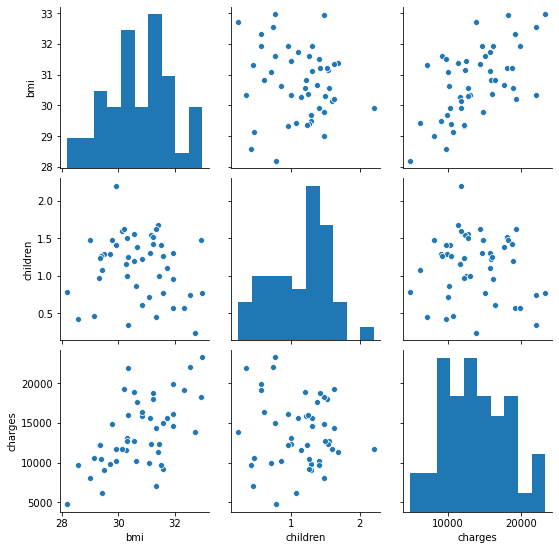

In [123]:
age = zd.groupby("age").mean()


array([[<AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'children'}>],
       [<AxesSubplot:title={'center':'charges'}>, <AxesSubplot:>]],
      dtype=object)

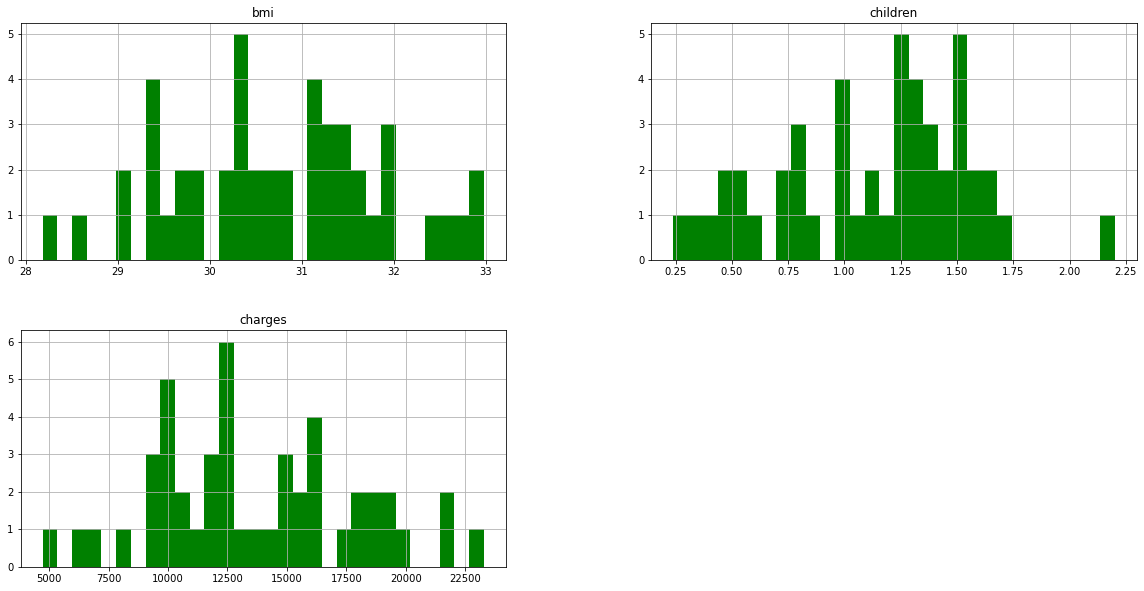

In [124]:
age.hist(bins = 30, figsize = (20,10), color = 'g')

In [125]:
zd['sex'].unique()

array(['female', 'male'], dtype=object)

In [130]:
zd['sex']=zd['sex'].apply(lambda x: 0 if x=='female' else 1)
zd.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,yes,southwest,16884.92400
1,18,1,33.770,1,no,southeast,1725.55230
2,28,1,33.000,3,no,southeast,4449.46200
3,33,1,22.705,0,no,northwest,21984.47061
4,32,1,28.880,0,no,northwest,3866.85520


In [131]:
zd['smoker']=zd['smoker'].apply(lambda x: 0 if x=='no' else 1)
zd.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [133]:
region = pd.get_dummies(zd['region'], drop_first=True)
region.head()

,northwest,southeast,southwest
0,0,0,1
1,0,1,0
2,0,1,0
3,1,0,0
4,1,0,0


In [135]:
zd = pd.concat([zd, region], axis=1)
zd.head()

,age,sex,bmi,children,smoker,region,charges,northwest,southeast,southwest
0,19,1,27.900,0,1,southwest,16884.92400,0,0,1
1,18,1,33.770,1,0,southeast,1725.55230,0,1,0
2,28,1,33.000,3,0,southeast,4449.46200,0,1,0
3,33,1,22.705,0,0,northwest,21984.47061,1,0,0
4,32,1,28.880,0,0,northwest,3866.85520,1,0,0


In [136]:
zd.drop('region', axis=1)

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
0,19,1,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,1,0,0
1334,18,1,31.920,0,0,2205.98080,0,0,0
1335,18,1,36.850,0,0,1629.83350,0,1,0
1336,21,1,25.800,0,0,2007.94500,0,0,1


In [139]:
zd[['age', 'bmi', 'charges']].mean()

age           39.207025
bmi           30.663397
charges    13270.422265
dtype: float64

In [140]:
zd[['age', 'bmi', 'charges']].std()

age           14.049960
bmi            6.098187
charges    12110.011237
dtype: float64

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>],
       [<AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'children'}>],
       [<AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'charges'}>]], dtype=object)

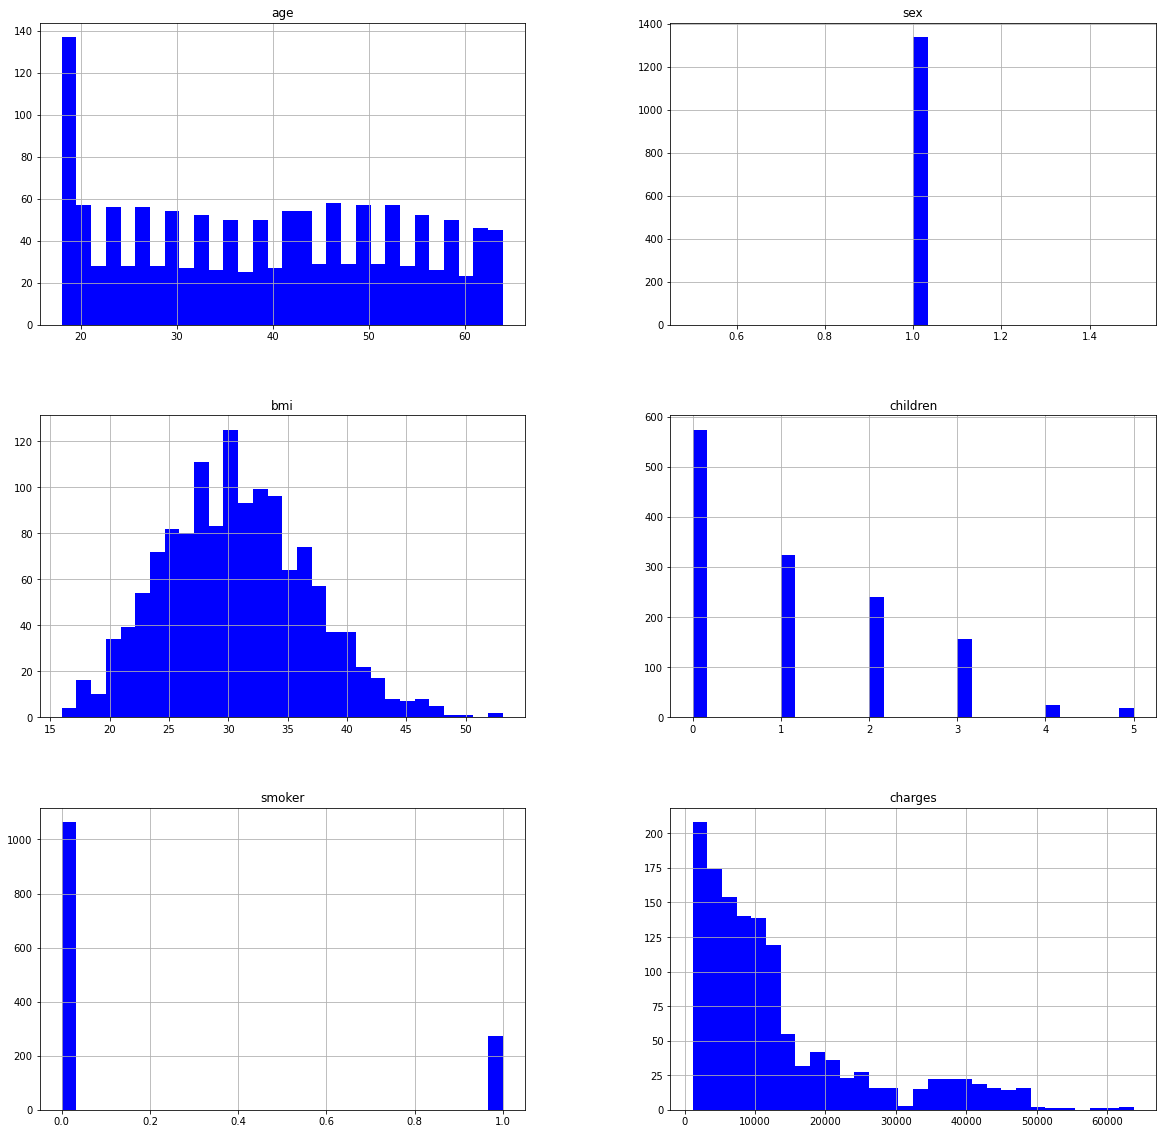

In [142]:
zd[['age', 'sex', 'bmi', 'children', 'smoker', 'charges']].hist(bins = 30, figsize = (20,20), color = 'b')



<AxesSubplot:xlabel='age', ylabel='charges'>

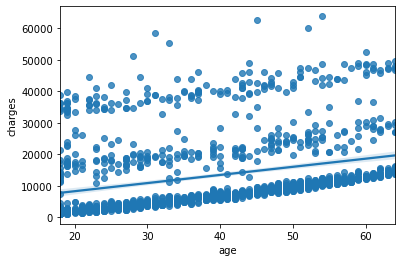

In [148]:
sns.regplot(x='age', y='charges', data=zd, )

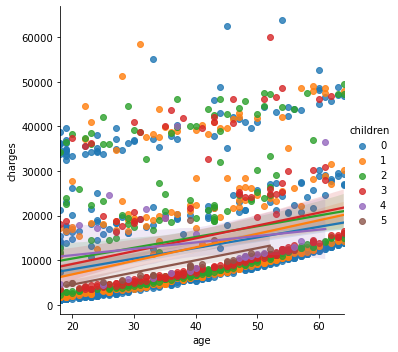

In [155]:
g = sns.lmplot(x="age", y="charges", hue="children", data=zd)

In [158]:
cor = zd[['bmi', 'charges', 'children', 'smoker']].corr()
cor

,bmi,charges,children,smoker
bmi,1.000000,0.198341,0.012759,0.003750
charges,0.198341,1.000000,0.067998,0.787251
children,0.012759,0.067998,1.000000,0.007673
smoker,0.003750,0.787251,0.007673,1.000000


<AxesSubplot:>

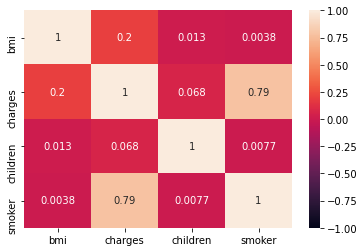

In [169]:
sns.heatmap(cor, vmin=-1, vmax=+1, annot=True)

In [161]:
#Kreiramoo trening i test model
X = zd.drop(columns =['charges'])
y = zd['charges']

In [163]:
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [166]:
X = np.array(X[['age', 'sex', 'bmi', 'children', 'smoker']]).astype('float32')
y = np.array(y).astype('float32')

In [173]:
y = y.reshape(-1,1)
y.shape

(1338, 1)

In [174]:
#scaling the data before feeding the model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)

In [180]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [183]:
# using linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

regzd = LinearRegression()
regzd.fit(X_train, y_train)

LinearRegression()

In [184]:
regzd_acc = regzd.score(X_test, y_test)
regzd_acc

0.734606665129248

In [185]:
regzd_acc = regzd.score(X_train, y_train)
regzd_acc

0.7510077247065257

In [186]:
y_pred=regzd.predict(X_test)

In [195]:
#Obrćemo u izvorne vrednosti kako bi nam greška bila interpretabilnija

y_predict_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test)



In [192]:
#k broj parametara n broj ispitanika veličina uzorka
k = X_test.shape[1]
n = len(X_test)

In [196]:
y_predict_orig.shape

(268, 1)

In [197]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_predict_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_predict_orig)

In [198]:
MAE=mean_absolute_error(y_test_orig,y_predict_orig)
R2=r2_score(y_test_orig,y_predict_orig)
AdjR2=1-(1-R2)*(n-1)/(n-k-1)

In [199]:
print('RMSE=',RMSE,'\nMSE=',MSE, '\nMAE=',MAE, '\nR2=',R2, '\nAdjR2=',AdjR2)

RMSE= 5532.613 
MSE= 30609812.0 
MAE= 3857.9883 
R2= 0.7346066558430624 
AdjR2= 0.729541897366785


# Modeling via SAGEMAKER (project 2)

Sve je isto kao pre

In [212]:
#Koristimo neuralnu ANN Dense mrežu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 50)                300       
_________________________________________________________________
activation_8 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 150)               7650      
_________________________________________________________________
activation_9 (Activation)    (None, 150)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 150)               22650     
_________________________________________________________________
activation_10 (Activation)   (None, 150)              

In [255]:
zd['sex']=zd['sex'].apply(lambda x: 0 if x=='female' else 1)
zd.head()

,age,sex,bmi,children,smoker,region,charges,northwest,southeast,southwest
0,19,1,27.900,0,1,southwest,16884.92400,0,0,1
1,18,1,33.770,1,0,southeast,1725.55230,0,1,0
2,28,1,33.000,3,0,southeast,4449.46200,0,1,0
3,33,1,22.705,0,0,northwest,21984.47061,1,0,0
4,32,1,28.880,0,0,northwest,3866.85520,1,0,0


In [256]:
zd=zd.drop("region", axis=1)

In [257]:
#Kreiramoo trening i test model
X = zd.drop(columns =['charges'])
y = zd['charges']

In [258]:
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [259]:
y=y.reshape(-1,1)

In [260]:
#scaling the data before feeding the model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)

In [261]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [264]:
# optimizer = Adam()
#Menjamoo aktivacione funkcije, završna aktivaciona funkcija je linear
#pošto imamo regresioni problem
#input_dim je ulazni broj prediktora
#dropout je mera regularizacije putem koje opisujemo koji procenat neurona slučajno
#gasimo u kom layer-u kako bismo izbegli overfitovanje
ANN_model = keras.Sequential()
ANN_model.add(Dense(50, input_dim = 8))
ANN_model.add(Activation('relu'))
ANN_model.add(Dense(150))
ANN_model.add(Activation('relu'))
ANN_model.add(Dropout(0.5))
ANN_model.add(Dense(150))
ANN_model.add(Activation('relu'))
ANN_model.add(Dropout(0.5))
ANN_model.add(Dense(50))
ANN_model.add(Activation('linear'))
ANN_model.add(Dense(1))
ANN_model.compile(loss = 'mse', optimizer = 'adam')
ANN_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 50)                450       
_________________________________________________________________
activation_16 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 150)               7650      
_________________________________________________________________
activation_17 (Activation)   (None, 150)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 150)               22650     
_________________________________________________________________
activation_18 (Activation)   (None, 150)              

In [265]:
#Kompajliramo i pokrećemo model
#Koristimo Adaptivni metod za stohastičku optimizaciju
#koristimo mini-batch učenje od dvadeset ispitanika koji ulaze postepeno u proces učenja
#a mreža će proći 100 puta kroz podatke, od inputa do outputa prilikom upotrebe
#backpropagation algoritma na osnovu koga ažurira koeficijente tražeći lokalni minimum
#learning rate je defoltni
ANN_model.compile(optimizer='Adam', loss='mean_squared_error')

epochs_hist = ANN_model.fit(X_train, y_train, epochs = 100, batch_size = 20, validation_split = 0.2)

Epoch 1/100
43/43 [==============================] - 0s 3ms/step - loss: 0.6754 - val_loss: 0.2263
Epoch 2/100
43/43 [==============================] - 0s 1ms/step - loss: 0.3822 - val_loss: 0.1819
Epoch 3/100
43/43 [==============================] - 0s 1ms/step - loss: 0.3116 - val_loss: 0.1836
Epoch 4/100
43/43 [==============================] - 0s 1ms/step - loss: 0.2812 - val_loss: 0.1779
Epoch 5/100
43/43 [==============================] - 0s 1ms/step - loss: 0.2539 - val_loss: 0.1669
Epoch 6/100
43/43 [==============================] - 0s 1ms/step - loss: 0.2453 - val_loss: 0.1702
Epoch 7/100
43/43 [==============================] - 0s 1ms/step - loss: 0.2568 - val_loss: 0.1716
Epoch 8/100
43/43 [==============================] - 0s 1ms/step - loss: 0.2358 - val_loss: 0.1706
Epoch 9/100
43/43 [==============================] - 0s 1ms/step - loss: 0.2409 - val_loss: 0.1818
Epoch 10/100
43/43 [==============================] - 0s 1ms/step - loss: 0.2265 - val_loss: 0.1774
Epoch 11/

43/43 [==============================] - 0s 2ms/step - loss: 0.1590 - val_loss: 0.1751
Epoch 84/100
43/43 [==============================] - 0s 1ms/step - loss: 0.1463 - val_loss: 0.1758
Epoch 85/100
43/43 [==============================] - 0s 1ms/step - loss: 0.1530 - val_loss: 0.1683
Epoch 86/100
43/43 [==============================] - 0s 1ms/step - loss: 0.1464 - val_loss: 0.1752
Epoch 87/100
43/43 [==============================] - 0s 1ms/step - loss: 0.1513 - val_loss: 0.1807
Epoch 88/100
43/43 [==============================] - 0s 1ms/step - loss: 0.1501 - val_loss: 0.1751
Epoch 89/100
43/43 [==============================] - 0s 1ms/step - loss: 0.1502 - val_loss: 0.1718
Epoch 90/100
43/43 [==============================] - 0s 1ms/step - loss: 0.1461 - val_loss: 0.1769
Epoch 91/100
43/43 [==============================] - 0s 1ms/step - loss: 0.1470 - val_loss: 0.1773
Epoch 92/100
43/43 [==============================] - 0s 1ms/step - loss: 0.1478 - val_loss: 0.1667
Epoch 93/100


In [266]:
result = ANN_model.evaluate(X_test, y_test)
accuracy_ANN = 1 - result
print("Accuracy : {}".format(accuracy_ANN))

9/9 [==============================] - 0s 604us/step - loss: 0.1462
Accuracy : 0.8538484275341034


In [267]:
epochs_hist.history.keys()

dict_keys(['loss', 'val_loss'])

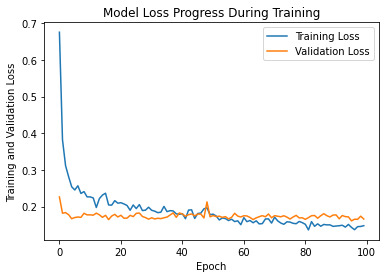

In [268]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])

Text(0, 0.5, 'True Values')

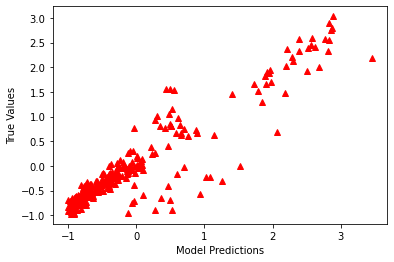

In [269]:
y_predict = ANN_model.predict(X_test)
plt.plot(y_test, y_predict, "^", color = 'r')
plt.xlabel('Model Predictions')
plt.ylabel('True Values')

In [270]:
y_predict_orig = scaler_y.inverse_transform(y_predict)
y_test_orig = scaler_y.inverse_transform(y_test)

In [271]:
k = X_test.shape[1]
n = len(X_test)
n

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_predict_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_predict_orig)
MAE = mean_absolute_error(y_test_orig, y_predict_orig)
r2 = r2_score(y_test_orig, y_predict_orig)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 4627.899 
MSE = 21417454.0 
MAE = 2959.0872 
R2 = 0.858559378749388 
Adjusted R2 = 0.8541905564713769
